# GEM

$$
\mathcal{L} = 
$$

In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training import GEM
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch import cuda

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.plugins import WeightStoragePlugin

# Constants

In [5]:
TORCH_DEVICE = "cuda" if cuda.is_available() else "cpu"
N_EXPERIENCES = 5
EXPERIMENT_SEED = 1234
METRICS_SUBFOLDER = f"class_saturation/{N_EXPERIENCES}"
METRICS_FILENAME = f"{METRICS_SUBFOLDER}/gem.pkl"

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
scenario = PermutedMNIST(N_EXPERIENCES, seed=EXPERIMENT_SEED, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

In [8]:
best_hyperparameters = {
    'patterns_per_exp': 2,
    'memory_strength': 0.5
}

## Evaluation metrics definition

In [9]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=TORCH_DEVICE),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")
/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


## Plugin defitinitions

In [10]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [11]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(TORCH_DEVICE)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
criterion = CrossEntropyLoss().to(TORCH_DEVICE)
strategy = GEM(
    model,
    optimizer,
    criterion,
    train_epochs=5,
    train_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    eval_mb_size=128,
    device=TORCH_DEVICE,
    **best_hyperparameters
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

  0%|          | 0/5 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 469/469 [00:04<00:00, 113.44it/s]
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 112.7000
	Loss_MB/train_phase/train_stream/Task000 = 1.2691
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.1355
100%|██████████| 469/469 [00:03<00:00, 124.46it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 107.4000
	Loss_MB/train_phase/train_stream/Task000 = 0.8512
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.7693
100%|██████████| 469/469 [00:03<00:00, 122.74it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 114.3000
	Loss_MB/train_phase/train_stream/Task000 = 0.6100
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.8215
100%|██████████| 469/469 [00:03<00:00, 125.29it/s]
Epoch 3 ended.
	CPUUsage_MB/train_phase/train_

 20%|██        | 1/5 [00:23<01:33, 23.41s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.4291
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x15383eb80>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2402.2305
	EvalStream/Acc_Matrix = 
tensor([[0.9156, 0.1172, 0.1419, 0.1449, 0.1330],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	Loss_Stream/eval_phase/test_stream/Task000 = 2.3440
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 334.9375
	StreamBWT/eval_phase/test_stream = 0.0000
	StreamForgetting/eval_phase/test_stream = 0.0000
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.2905
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.2365
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0.

 40%|████      | 2/5 [01:34<02:33, 51.26s/it]


	CPUUsage_Stream/eval_phase/test_stream/Task000 = 145.6815
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x153dc1fd0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2410.6748
	EvalStream/Acc_Matrix = 
tensor([[0.9156, 0.1172, 0.1419, 0.1449, 0.1330],
        [0.8854, 0.9283, 0.1266, 0.1196, 0.1414],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	Loss_Stream/eval_phase/test_stream/Task000 = 1.9112
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 204.3281
	StreamBWT/eval_phase/test_stream = -0.0302
	StreamForgetting/eval_phase/test_stream = 0.0302
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.4403
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.4176
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0.3991
	Top1_ClassAcc_Stream/e

 60%|██████    | 3/5 [02:52<02:07, 63.78s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 139.3550
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1542be970>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2439.1104
	EvalStream/Acc_Matrix = 
tensor([[0.9156, 0.1172, 0.1419, 0.1449, 0.1330],
        [0.8854, 0.9283, 0.1266, 0.1196, 0.1414],
        [0.8483, 0.8432, 0.9353, 0.1103, 0.1198],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	Loss_Stream/eval_phase/test_stream/Task000 = 1.6797
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 208.5156
	StreamBWT/eval_phase/test_stream = -0.0762
	StreamForgetting/eval_phase/test_stream = 0.0762
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.5714
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.5873
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0

 80%|████████  | 4/5 [04:19<01:12, 72.75s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 140.5491
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x154231eb0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2439.1104
	EvalStream/Acc_Matrix = 
tensor([[0.9156, 0.1172, 0.1419, 0.1449, 0.1330],
        [0.8854, 0.9283, 0.1266, 0.1196, 0.1414],
        [0.8483, 0.8432, 0.9353, 0.1103, 0.1198],
        [0.7897, 0.8269, 0.9091, 0.9362, 0.0863],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])
	Loss_Stream/eval_phase/test_stream/Task000 = 1.0981
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 208.4062
	StreamBWT/eval_phase/test_stream = -0.0845
	StreamForgetting/eval_phase/test_stream = 0.0845
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.7096
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.7633
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0

100%|██████████| 5/5 [05:49<00:00, 69.97s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 136.6631
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14d3061f0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 1084.0664
	EvalStream/Acc_Matrix = 
tensor([[0.9156, 0.1172, 0.1419, 0.1449, 0.1330],
        [0.8854, 0.9283, 0.1266, 0.1196, 0.1414],
        [0.8483, 0.8432, 0.9353, 0.1103, 0.1198],
        [0.7897, 0.8269, 0.9091, 0.9362, 0.0863],
        [0.7272, 0.7951, 0.8749, 0.8485, 0.9387]])
	Loss_Stream/eval_phase/test_stream/Task000 = 0.6334
	MaxGPUcpuUsage_Stream/eval_phase/test_stream/Task000 = 0
	MaxRAMUsage_Stream/eval_phase/test_stream/Task000 = 212.1719
	StreamBWT/eval_phase/test_stream = -0.1174
	StreamForgetting/eval_phase/test_stream = 0.1174
	Top1_Acc_Stream/eval_phase/test_stream/Task000 = 0.8369
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/0 = 0.9018
	Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/1 = 0

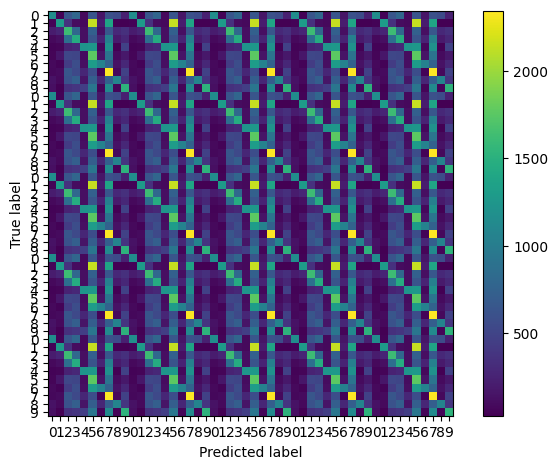

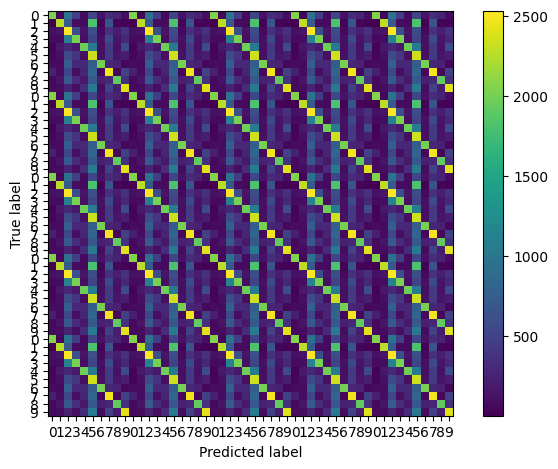

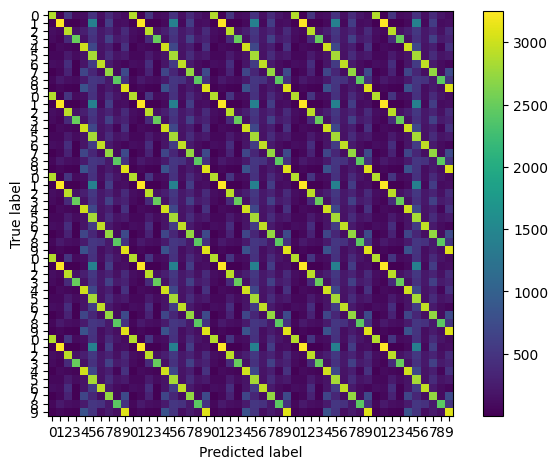

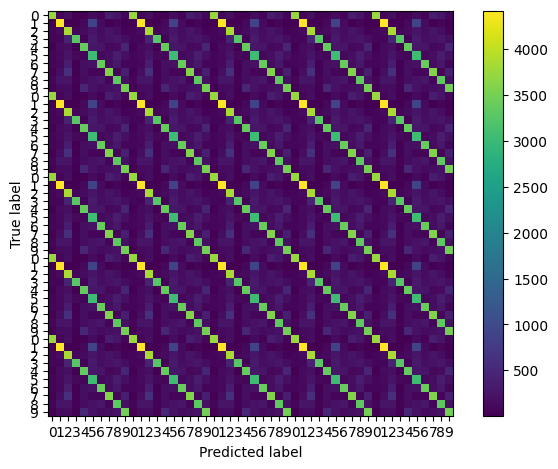

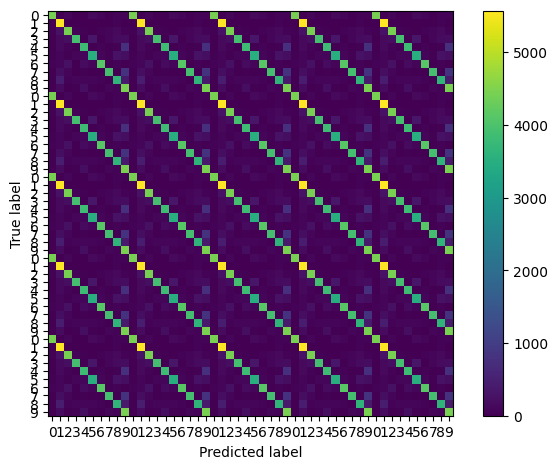

In [12]:
for experience in tqdm(train_stream):
    strategy.train(experience)
    strategy.eval(test_stream)

# Get metrics

In [13]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(N_EXPERIENCES):
    filled_i = str(i).zfill(3)
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [14]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [15]:
weights = model_plugins[0].weights

# Store metrics

In [16]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "weights": weights
}, open(SAVED_METRICS_PATH / METRICS_FILENAME, "wb"))